# Coding Tutorial 7 - Recurrent Neural Networks

```
Course: CSCI 5922 Spring 2025, University of Colorado Boulder
TA: Everley Tseng
Email: Yu-Yun.Tseng@colorado.edu
* AI assistant is used in making this tutorial
```

## Overview

Sections:
- Recurrent layers: RNN, LSTM, and GRU
- Character prediction
- Tanh vs. ReLU in RNN


Objectives:
- Learn how to code recurrent layers
- Learn how to train a simple character prediction model
- Compare tanh and ReLU for activation in RNN

## Recurrent Neural Networks

For model summary, we will use the package `torchinfo` instead of `torchsummary`. As `torchsummary` cannot summarize complex data structures, you might run into errors when using some recurrent layers.

In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

Similar to having `nn.Linear` and `nn.Conv2d`, PyTorch also has  modules for recurrent layers such as `nn.RNN`, `nn.LSTM`, and `nn.GRU`. In this tutorial, we will build three simple recurrent models using RNN, LSTM, and GRU layers, respectively, for character prediction.

What is character prediction? Given a string "How are yo", predict the next character: "u". The input string is a sequential data, where there is a time-step correlation in:
```
H -> o -> w -> space -> a -> r -> e -> space -> y -> o -> u
```
Therefore, we will be passing the input **character by character** into the model to predict the most likely upcoming character.


### RNN

The major difference in recurrent layers from the layers we have used is that the hidden states are recurred over time steps. This makes the shapes of inputs, outputs, and hidden states. Let's read the documentation for the RNN layer first: [`nn.RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

From the `forward` implementation, we see that the layer takes in **2 elements** and returns **2 elements**. This aligns with what we know about an RNN unit where there is a hidden state $h_t$ that passes over time steps. Following this format, assmue we have the forward pass of an RNN layer as:
```
out, h2 = rnn_layer(in, h1)
```
The shape of these elements will be:
- Input `in`: `(batch_size, seq_length, feature_size)`
- Hidden states `h1` and `h2`: `(1, batch_size, hidden_size)`
- Output `out`: `(batch_size, seq_length, hidden_size)`

Both `in` and `out` accumulate over time steps (i.e., with the `seq_length` dimension), and the hidden state changes over time. Note that you are able to assign the dimension order for `batch_size` and `seq_length` by setting `batch_first=True` or `batch_first=False` in the RNN layer.



Below, we practice building an RNN classification model with one recurrent layer followed by a fully-connected layer.  Note that in the **first time step**, there is no prior hidden state so we will initialize a hidden state for it (which is usually zeros). For the RNN layer output, we take the intermediate feature from the **final time step** istead of the entire sequence as we are only predicting the one upcoming character.

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()

        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden=None):
        # Pass in zeros when there is no prior hidden state
        if hidden is None:
            hidden = torch.zeros(1, x.size(0), self.hidden_size)

        # RNN layer
        rnn_out, hidden = self.rnn(x, hidden)

        # Fully-connected layer
        output = self.fc(rnn_out[:, -1, :]) # Take the last time step's output

        # Apply softmax for classification
        output = self.softmax(output)
        return output, hidden

In [ ]:
model = SimpleRNN(input_size=58, hidden_size=256, output_size=58)
summary(model, input_size=(1, 40, 58))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleRNN                                [1, 58]                   --
├─RNN: 1-1                               [1, 40, 256]              80,896
├─Linear: 1-2                            [1, 58]                   14,906
├─LogSoftmax: 1-3                        [1, 58]                   --
Total params: 95,802
Trainable params: 95,802
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.25
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.38
Estimated Total Size (MB): 0.47

### LSTM

The LSTM layer in PyTorch is [`nn.LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html). LSTM layer has two hidden states, $h_t$ and $C_t$, which is passed in the layer as a tuple:
```
out, (h2, C2) = rnn_layer(in, (h1, C1))
```
Adopt the structure of RNN model and adjust the hidden states to include both elements in LSTM

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden=None):
        if hidden is None:
            hidden = torch.zeros(1, x.size(0), self.hidden_size)  # Hidden state
            cell = torch.zeros(1, x.size(0), self.hidden_size)  # Cell state
            hidden = (hidden, cell)  # LSTM requires a tuple of (hidden_state, cell_state)

        lstm_out, hidden = self.lstm(x, hidden)
        output = self.fc(lstm_out[:, -1, :])
        output = self.softmax(output)
        return output, hidden

In [ ]:
model = SimpleLSTM(input_size=58, hidden_size=256, output_size=58)
summary(model, input_size=(1, 40, 58))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleLSTM                               [1, 58]                   --
├─LSTM: 1-1                              [1, 40, 256]              323,584
├─Linear: 1-2                            [1, 58]                   14,906
├─LogSoftmax: 1-3                        [1, 58]                   --
Total params: 338,490
Trainable params: 338,490
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 12.96
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 1.35
Estimated Total Size (MB): 1.45

### GRU

In [ ]:
import torch
import torch.nn as nn

class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleGRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden=None):
        if hidden is None:
            hidden = torch.zeros(1, x.size(0), self.hidden_size)  # GRU only has hidden state

        gru_out, hidden = self.gru(x, hidden)
        output = self.fc(gru_out[:, -1, :])  # Take the last time step's output
        output = self.softmax(output)
        return output, hidden

In [ ]:
model = SimpleGRU(input_size=58, hidden_size=256, output_size=58)
summary(model, input_size=(1, 40, 58))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleGRU                                [1, 58]                   --
├─GRU: 1-1                               [1, 40, 256]              242,688
├─Linear: 1-2                            [1, 58]                   14,906
├─LogSoftmax: 1-3                        [1, 58]                   --
Total params: 257,594
Trainable params: 257,594
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 9.72
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 1.03
Estimated Total Size (MB): 1.12

## Character Prediction

Load data from the given [url](https://s3.amazonaws.com/text-datasets/nietzsche.txt). Use the string `full_text` to store the entire corpus. There are 600901 characters in total.

In [ ]:
import requests

text_url = 'https://s3.amazonaws.com/text-datasets/nietzsche.txt'
response = requests.get(text_url)
response.raise_for_status()
lines = response.text.splitlines()
full_text = ' '.join(lines)
print('Total # of characters in corpus:', len(full_text))
print('Print first 500 characters:', full_text[:500])

Total # of characters in corpus: 600901
Print first 500 characters: PREFACE   SUPPOSING that Truth is a woman--what then? Is there not ground for suspecting that all philosophers, in so far as they have been dogmatists, have failed to understand women--that the terrible seriousness and clumsy importunity with which they have usually paid their addresses to Truth, have been unskilled and unseemly methods for winning a woman? Certainly she has never allowed herself to be won; and at present every kind of dogma stands with sad and discouraged mien--IF, indeed, it s


### Data Processing

We need to prepare a dataset for training a **character prediction** model. Let's start with breaking down this task: Given $n$ characters, predict the ${n+1}^{th}$ character.

Assume that we have a corpus that has 21 characters in total, **"Deep Learning is fun."** We will use this corpus as an example for the following steps:

- **Step 1:** Convert all characters to lowercase
```
"Deep Learning is fun." -> "deep learning is fun."
```
- **Step 2:** Calculate the number of unique characters in the corpus (i.e., 14)
```
"d", "e", "p", " ", "l", "a", "r", "n", "i", "g", "s", "f", "u", "."
```
- **Step 3:** Use one-hot encoding to encode each character. For instance, our dictionary size is 14, so the length of each character encoding is 14.
```
"d": [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
"e": [0 1 0 0 0 0 0 0 0 0 0 0 0 0]
"p": [0 0 1 0 0 0 0 0 0 0 0 0 0 0]
" ": [0 0 0 1 0 0 0 0 0 0 0 0 0 0]
"l": [0 0 0 0 1 0 0 0 0 0 0 0 0 0]
...
".": [0 0 0 0 0 0 0 0 0 0 0 0 0 1]
```
- **Step 4:** Create training data (`x` and `y`) using a sliding window. Determine a window size $n$, e.g., $n=5$. Determine a window step $s$, e.g., $s=1$. The smaller the step is, the more samples we have.
```
Corpus: "deep learning is fun."
sample 1: x=[deep ], y=[l]
sample 2: x=[eep l], y=[e]
sample 3: x=[ep le], y=[a]
sample 4: x=[p lea], y=[r]
sample 5: x=[ lear], y=[n]
sample 6: x=[learn], y=[i]
...
```

- **Step 5:** Using the one-hot encoding dictionary created in **step 3**, convert all training data to the encoded style. Take sample 1 as an example:
```
sample 1 x:
"deep " is converted to a 5 x 14 embedding
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0],
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0],
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0],
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0],
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0]]
sample 1 y:
"l" is converted to a 1 x 14 embedding
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
```
So, each training sample will have `x` with the shape `(seq_length, feature_size)` and `y` with the shape `(feature_size)`

Now, let's start processing our data!

In [ ]:
# Convert to lowercases
full_text = full_text.lower()

# Create a character dictionary
char_dict = sorted(set(full_text))

print('{} characters'.format(len(char_dict)))

58 characters


There are $58$ characters in this corpus, so our one-hot encoding features will be the size of $58$.

In [ ]:
# Create a dictionary for one-hot encoding
# key: character, value: encoding
encoder = {}

for ind, char in enumerate(char_dict):
    tensor = torch.zeros(len(char_dict)) # create an all-zero array
    tensor[ind] = 1                      # flag the index of the charactre as 1
    encoder[char] = tensor               # save to the encoder dict

char_ind_map = {ind:char for ind, (char, _) in enumerate(encoder.items())}

Set up a proper window size and a proper step size to generate samples for training.

In [ ]:
window_size = 40
window_step = 10

x_train = []
y_train = []

for i in range(0, len(full_text)-window_size, window_step):
    # Sample x and y from corpus
    x = full_text[i:i+window_size]
    y = full_text[i+window_size]

    # Convert characters to encoding
    x_encoded = torch.stack([encoder[c] for c in x])
    y_encoded = encoder[y]
    x_train.append(x_encoded)
    y_train.append(y_encoded)

x_train = torch.stack(x_train)
y_train = torch.stack(y_train)

print('Input shape: {}. Output shape: {}'.format(x_train.shape, y_train.shape))

Input shape: torch.Size([60087, 40, 58]). Output shape: torch.Size([60087, 58])


Now that the samples are ready, use `DataLoader` to wrap the dataset.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 256
dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Model Training

We'll be training the RNN, LSTM, and GRU models and compare their results. Record the training loss and training time for comparison.

In [ ]:
import time

def train_model(model, lr=0.001, n_epochs=10):

    criterion = nn.NLLLoss()  # Negative Log-Likelihood Loss (used with LogSoftmax)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    epoch_times = []

    for epoch in range(n_epochs):
        total_loss = 0

        start_time = time.time()  # Record start time
        for batch_x, batch_y in train_loader:
            batch_size = batch_x.size(0)
            optimizer.zero_grad()
            output, hidden = model(batch_x)
            loss = criterion(output, batch_y.argmax(dim=1))  # Convert one-hot y to indices
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        end_time = time.time()  # Record end time

        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")
        losses.append(avg_loss)
        epoch_times.append(end_time-start_time)
    avg_time = np.mean(epoch_times)
    print("Training complete! Average computation time is {:.2f} per epoch".format(avg_time))
    return model

In [ ]:
input_size = 58
hidden_size = 256
output_size = 58

The recurrent model training takes a long time, so we will only demonstrate the RNN model results.

In [ ]:
rnn_model = SimpleRNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
rnn_model = train_model(rnn_model, n_epochs=30)

Epoch 1/30, Loss: 2.8316
Epoch 2/30, Loss: 2.3865
Epoch 3/30, Loss: 2.2403
Epoch 4/30, Loss: 2.1532
Epoch 5/30, Loss: 2.0826
Epoch 6/30, Loss: 2.0243
Epoch 7/30, Loss: 1.9710
Epoch 8/30, Loss: 1.9199
Epoch 9/30, Loss: 1.8761
Epoch 10/30, Loss: 1.8317
Epoch 11/30, Loss: 1.7902
Epoch 12/30, Loss: 1.7512
Epoch 13/30, Loss: 1.7129
Epoch 14/30, Loss: 1.6790
Epoch 15/30, Loss: 1.6451
Epoch 16/30, Loss: 1.6147
Epoch 17/30, Loss: 1.5810
Epoch 18/30, Loss: 1.5469
Epoch 19/30, Loss: 1.5183
Epoch 20/30, Loss: 1.4888
Epoch 21/30, Loss: 1.4618
Epoch 22/30, Loss: 1.4322
Epoch 23/30, Loss: 1.4035
Epoch 24/30, Loss: 1.3778
Epoch 25/30, Loss: 1.3507
Epoch 26/30, Loss: 1.3262
Epoch 27/30, Loss: 1.3011
Epoch 28/30, Loss: 1.2772
Epoch 29/30, Loss: 1.2547
Epoch 30/30, Loss: 1.2292
Training complete! Average computation time is 33.28 per epoch


### Prediction

Using a random 40-character sample in the corpus, we can generate the next 50 characters using this trained model. As the model predicts the 41st character given the prior 40 characters, we will keep updating the input 40 characters using the predicted character.

In [ ]:
def generate_characters(model, hidden, input_text, input_size=40, n_char=50):
    output_text = input_text
    with torch.no_grad():
        for _ in range(n_char):
            x_encoded = torch.stack([encoder[c] for c in input_text]).unsqueeze(0) # encode input text
            output, hidden = model(x_encoded, hidden)
            predicted_index = output.argmax(dim=1).item()
            output_text = output_text + char_ind_map[predicted_index] # convert the predicted index to character
            input_text = output_text[-input_size:] # update the input text
    return output_text

In [ ]:
start_index = 103 # a random index
input_text = full_text[start_index:start_index+input_size]
print('* Input text:\n', input_text)

hidden = torch.zeros(1, 1, hidden_size) # create zeros for initial hidden state
output_text = generate_characters(rnn_model, hidden, input_text)
print('* Prediction:\n', output_text)

*Input text:
 sophers, in so far as they have been dogmatists, have fail
*Prediction:
 sophers, in so far as they have been dogmatists, have failed the dest procoust reatond and stand dessive and


You might notice that the first few generated characters make more sense, and the further into the predictions the worse it gets. This is due to the **recurrently updating input text using the predictions**. Once there is **error in the predictions**, it can cause a snowballing effect on the future predictions. This phenomenon is known as error accumulation, where incorrect outputs are fed back into the model as input, reinforcing deviations from meaningful text.

### RNN, LSTM, and GRU Comparison

To compare the computation time, let's run 3 epochs for the LSTM model and GRU model.

In [ ]:
lstm_model = SimpleLSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
lstm_model = train_model(lstm_model, n_epochs=3)

Epoch 1/3, Loss: 2.9286
Epoch 2/3, Loss: 2.4835
Epoch 3/3, Loss: 2.3060
Training complete! Average computation time is 140.63 per epoch


In [ ]:
gru_model = SimpleGRU(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
gru_model = train_model(gru_model, n_epochs=3)

Epoch 1/3, Loss: 2.7984
Epoch 2/3, Loss: 2.3469
Epoch 3/3, Loss: 2.1861
Training complete! Average computation time is 93.39 per epoch


From the results, we can see that the computation time is **LSTM > GRU > RNN**. To compare the prediction results, you can try running the LSTM and the GRU models for more epochs.

## ReLU in RNN

In [`nn.RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html), the default activation function is `tanh`, PyTorch also provides the option to use relu. In the previous models, tanh was used as the activation function.

In theory, ReLU is not an ideal choice for RNNs because it is sensitive to large inputs and does not handle negative values well. This can lead to instability, including exploding gradients or dying neurons (where neurons become inactive and output zero). To mitigate these issues, when selecting ReLU as the activation function, PyTorch recommends (and performs by default) a specific initialization method for the input-to-hidden weights:
```
torch.nn.init.kaiming_uniform_(rnn.weight_ih_l0, nonlinearity="relu")
```

However, without this initialization method, it will be very difficult to train an RNN layer with ReLU. Below, we test the RNN layer with two a uniform distribution [-1, 1] using the default `tanh` activation and `relu` activation, respectively.

In [ ]:
import torch.nn.init as init

class TanhRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TanhRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)

        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                init.uniform_(param, -1, 1)

    def forward(self, x, hidden=None):
        if hidden is None:
            hidden = torch.zeros(1, x.size(0), self.hidden_size)

        rnn_out, hidden = self.rnn(x, hidden)
        return rnn_out

class ReLURNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ReLURNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)

        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                init.uniform_(param, -1, 1)

    def forward(self, x, hidden=None):
        if hidden is None:
            hidden = torch.zeros(1, x.size(0), self.hidden_size)
        rnn_out, hidden = self.rnn(x, hidden)
        return rnn_out

Plot the mean values of outputs over **time steps**:

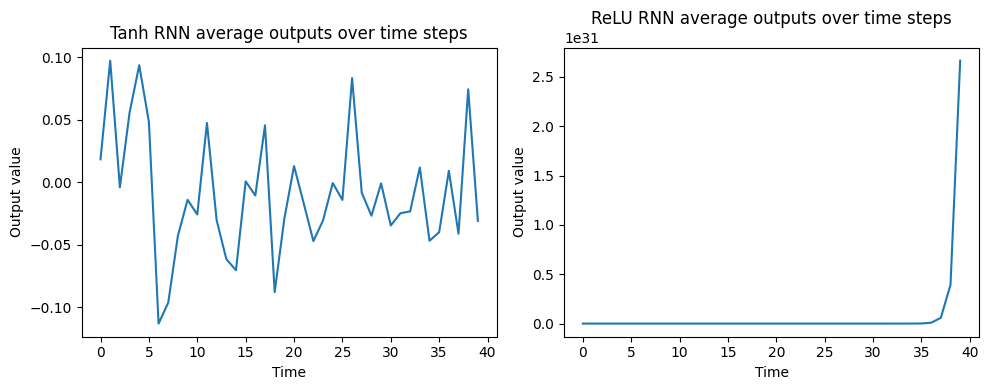

In [ ]:
# Run tanh model
tanh_rnn_model = TanhRNN(input_size=input_size, hidden_size=hidden_size)
rnn_out = tanh_rnn_model(x_train[:1,:,:])
tanh_out = np.mean(rnn_out.detach().numpy()[0], axis=1) # compute mean of all outputs in a time step

# Run relu model
relu_rnn_model = ReLURNN(input_size=input_size, hidden_size=hidden_size)
rnn_out = relu_rnn_model(x_train[:1,:,:])
relu_out = np.mean(rnn_out.detach().numpy()[0], axis=1) # compute mean of all outputs in a time step

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].set_title("Tanh RNN average outputs over time steps")
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Output value')
axes[0].plot(tanh_out)
axes[1].set_title("ReLU RNN average outputs over time steps")
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Output value')
axes[1].plot(relu_out)
plt.tight_layout()
plt.show()

The recurrent nature of RNN layers amplifies ReLU’s sensitivity over multiple time steps, potentially leading to an explosion of output and hidden state values. In contrast, tanh helps stabilize the output range, reducing the risk of uncontrolled growth and improving training stability.



## A Review of PyTorch Layers

As we are coming to an end of introducing basic model layers in PyTorch, this is a good time to summarize and review all the layers:
- Linear layers ([index](https://pytorch.org/docs/stable/nn.html#linear-layers))
- Convolution layers ([index](https://pytorch.org/docs/stable/nn.html#convolution-layers))
- Pooling layers ([index](https://pytorch.org/docs/stable/nn.html#pooling-layers))
- Recurrent layers ([index](https://pytorch.org/docs/stable/nn.html#recurrent-layers))
- Activation layers ([index](https://pytorch.org/docs/stable/nn.html#pooling-layers))
- Normalization layers ([index](https://pytorch.org/docs/stable/nn.html#normalization-layers))
- Dropout layers ([index](https://pytorch.org/docs/stable/nn.html#dropout-layers))

From Coding Tutorial 2 through Coding Tutorial 7, we practiced using these layers to customize model architectures. Below is the summary of steps toward using a layer in an architecture:
1. Go through the layer documentation. Make sure you understand the function (e.g., $Y = Wx + b$ for linear function).
2. Adjust the arguments to fit your archtecture needs (e.g., padding size, pooling size, dropout probability).
3. Apply the correct sizes for layer input and output (and hidden state if applicable) to connect it to other layers.

Many errors of shape mismatch come from the incorrect layer input and output shape. When debugging architecture issues, it can be very helpful to print the shapes of intermediate features.

## Review

Recurrent architectures are usually more time-consuming to train. To perform experiments, you can use shorter sequences (i.e., set up a smaller sequence window size).

You can complete the following tasks to practice coding recurrent architectures:
1. Use the `window_size=10` for the dataset. Train SimpleRNN, LSTM, and GRU for 15 epochs. Generate characters using the three models, respectively, and compare the results.
2. Create an RNN model using the architecture similar to `SimpleRNN`, and set up the activation gate to be `relu`. Without specifying parameter initialization method, the default kaiming should be applied. Train the model for 3 epochs. Do you see the explosion effect? Is the computation time faster or slower than when using tanh?

For any questions and discussions regarding this tutorial, attend [TA office hours](https://docs.google.com/spreadsheets/d/1fzfTJpEF7RaUYRA_NGa3DkiazdQXVj7QNBbp6DrEZ3I/edit?usp=sharing) or create a post on [Piazza](https://piazza.com/colorado/spring2025/csci5922/home) :) See you in the next tutorial!

\- Everley